# Homework 1 - Question 1

Imports

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# inline plot
%matplotlib inline
# default figure size
matplotlib.rcParams['figure.figsize'] = (20, 10)
# to make our sets reproducible
np.random.seed(42)
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
from typing import Tuple

#### Read the Data

In [3]:
data_path = Path('..') / 'data' / 'data1.parquet'
t = pq.read_table(data_path, memory_map=True)
df = t.to_pandas()

#### First Impressions - basic visual analysis of the data

Some basic statistics on the data:

In [4]:
df.describe()

,x,y
count,103.000000,103.000000
mean,150.760532,378.552109
std,207.175840,440.934505
min,-46.502102,-2113.874991
25%,56.481452,169.346111
50%,115.508293,376.712741
75%,182.925224,621.204894
max,1577.546447,1087.875467


We can clearly spot, with a naked eye, three outlier points, and aside from that somewhat of a linear dependence of y on x:

<AxesSubplot:xlabel='x', ylabel='y'>

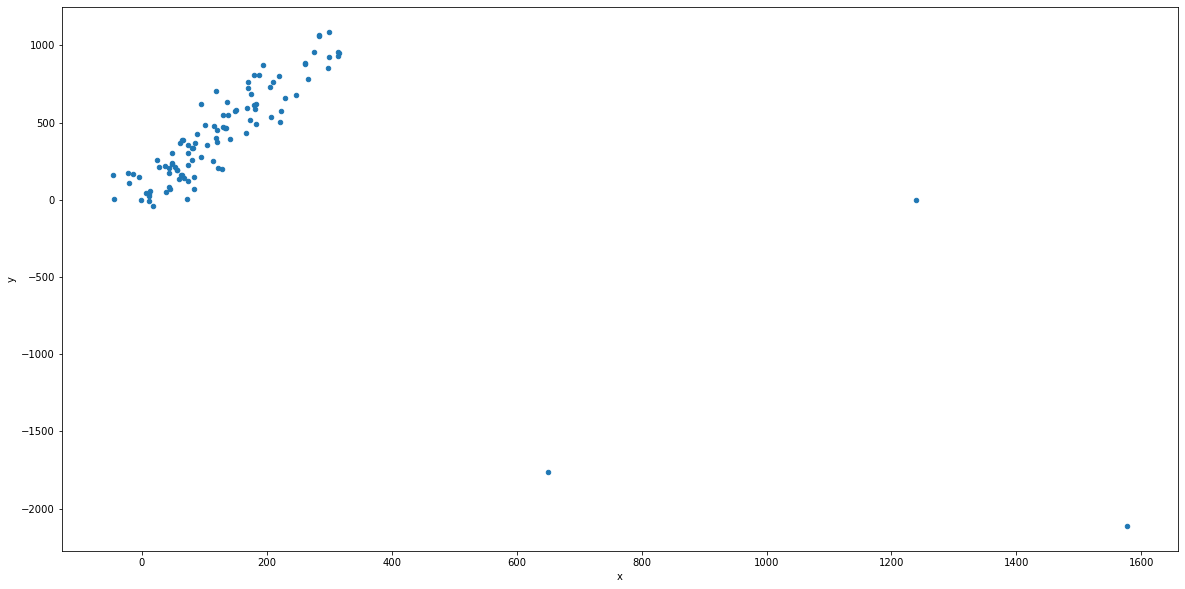

In [5]:
df.plot.scatter(x='x', y='y')

Extract $X$ and $y$ into arrays:

In [6]:
X = df.x.values.reshape(-1, 1)
y = df.y.values

### Linear Regression

First, let us find out what a simple linear regression produces with the outliers:

In [7]:
from sklearn.linear_model import LinearRegression
# include intercept
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(473.59661174765813, array([-0.63043358]))

Plot the linear function - obtained from linear regression, along with the data

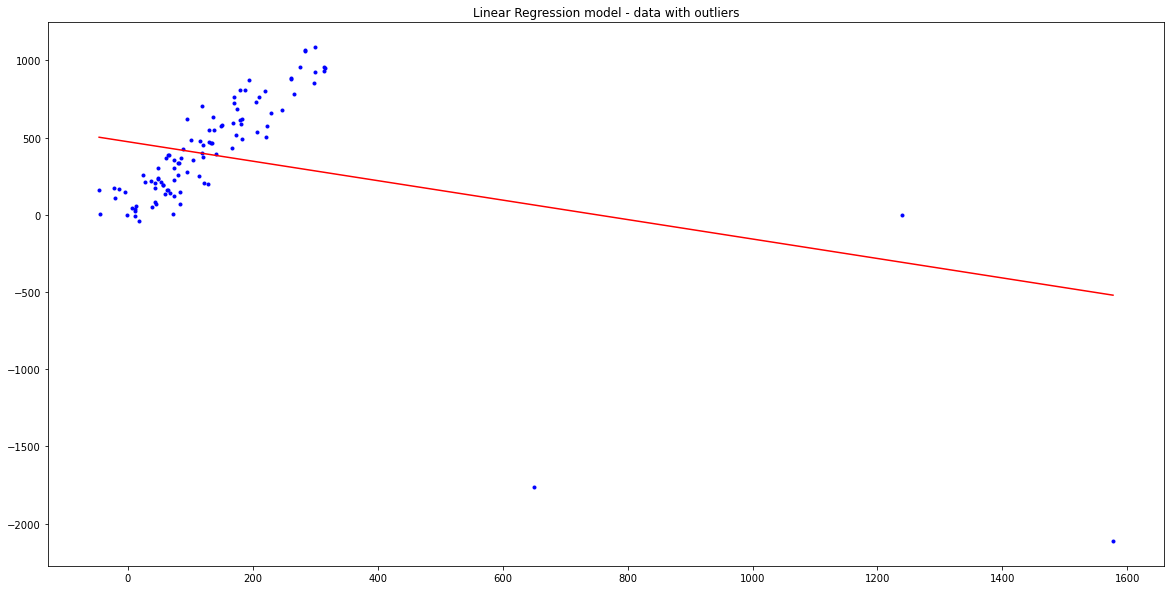

In [8]:
plt.plot(X, y, "b.")

xs = np.linspace(int(X.min()), int(X.max()), 100)[:, np.newaxis]
ys = lin_reg.predict(xs)
plt.plot(xs, ys, "r-", label='fit')
plt.title('Linear Regression model - data with outliers')

plt.show()

We can easily get rid of the three outliers by filtering on $x \geq 600$, for example:

<AxesSubplot:xlabel='x', ylabel='y'>

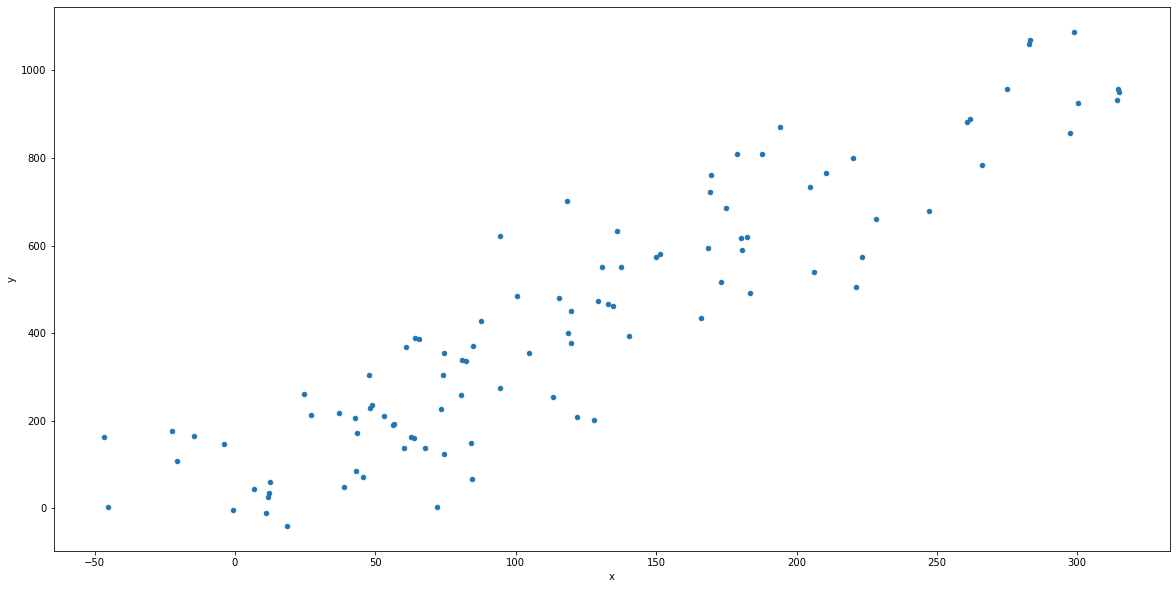

In [9]:
no_of_outliers = len(df.loc[df.x >= 600])
assert no_of_outliers == 3, "Outlier criteria is not good :("

df_clean = df.loc[df.x < 600]
df_clean.plot.scatter(x='x', y='y')

This looks more like a linear dependence. Let us look at some basic statistics on the "cleaned" data:

In [10]:
df_clean.describe()

,x,y
count,100.000000,100.000000
mean,120.610864,428.670316
std,90.831134,295.434906
min,-46.502102,-40.266686
25%,55.578232,187.904333
50%,109.120902,388.458643
75%,180.286207,625.516123
max,314.834760,1087.875467


Extract cleaned $X$ and $y$ arrays:

In [11]:
X_clean = df_clean.x.values.reshape(-1, 1)
y_clean = df_clean.y.values

Now, let us model a linear regression on the "cleaned" data:

In [12]:
# include intercept
lin_reg_clean = LinearRegression(fit_intercept=True)
lin_reg_clean.fit(X_clean, y_clean)
lin_reg_clean.intercept_, lin_reg_clean.coef_

(70.02365496350114, array([2.97358505]))

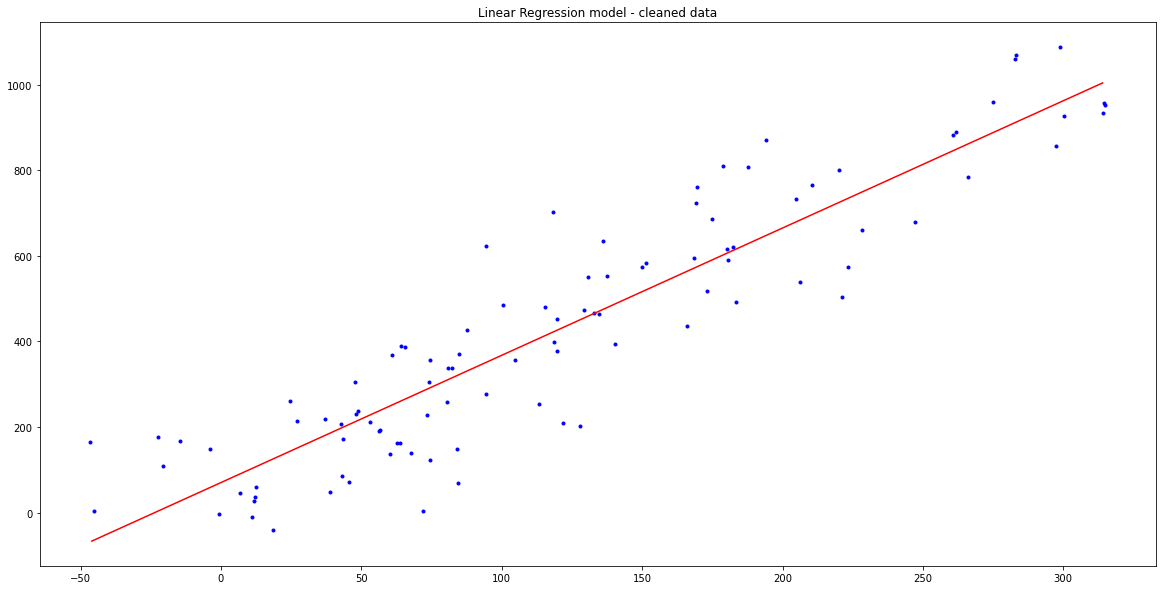

In [13]:
plt.plot(X_clean, y_clean, "b.")

xs = np.linspace(int(X_clean.min()), int(X_clean.max()), 100)[:, np.newaxis]
ys = lin_reg_clean.predict(xs)
plt.plot(xs, ys, "r-")
plt.title('Linear Regression model - cleaned data')

plt.show()

This looks good, although we didn't take into account measurement errors in $x$, which results in an underestimate of the coefficient, known as the attenuation bias.
The current linear function is:

In [14]:
f'y = {lin_reg_clean.coef_[0]} * x + {lin_reg_clean.intercept_}'

'y = 2.9735850481261794 * x + 70.02365496350114'

#### Let us make sure that we are using the right model by validating linear regression assumptions:

##### 1. Linear and Additive:

Text(0.5, 1.0, 'Residuals vs. Fitted')

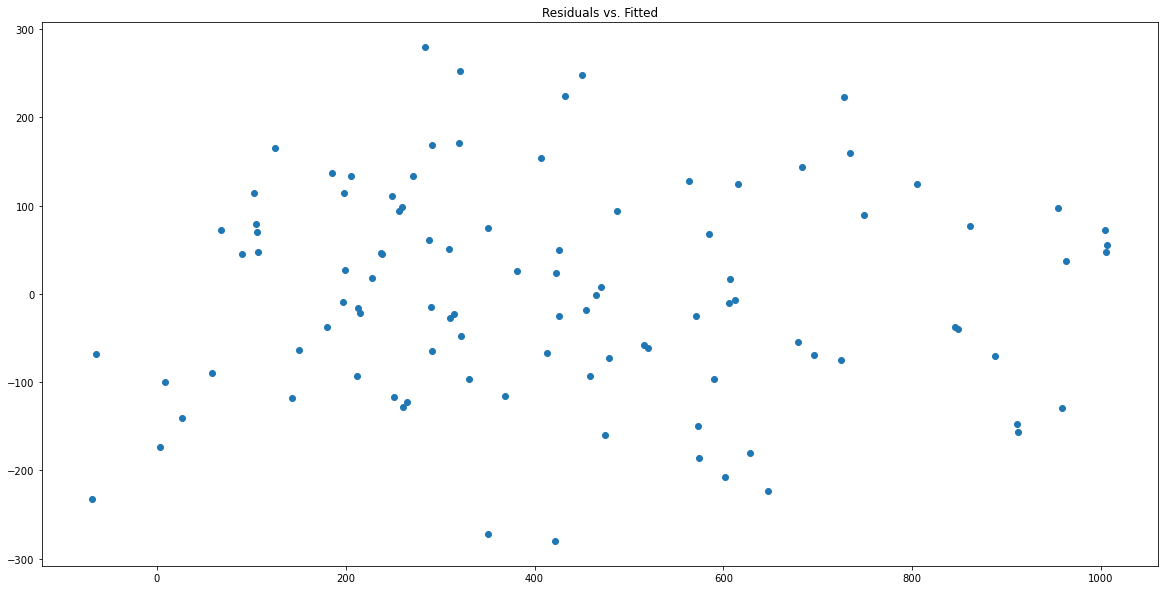

In [15]:
y_predicted = lin_reg_clean.predict(X_clean)

residuals = y_predicted - y_clean
plt.scatter(x=y_predicted, y=residuals)
plt.title('Residuals vs. Fitted')

There is no pattern evident in the 'Residuals vs. Fitted' scatter plot. This suggests linearity in the data.

##### 2. Autocorrelation:

In [16]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(residuals)

2.0331376813675752

We see that the Durbin - Watson (DW) statistic is ~2. Which means there is no autocorrelation.

##### 3. Multicollinearity: is irrelevant since we have only one independent variable.

##### 4. Heteroskedasticity:

Looking back at the 'Residuals vs. Fitted' scatter plot, there is no funnel-shape pattern exhibited. Thus, there is no Heteroskedasticity.

##### 5. Normal Distribution of error terms:

Let us analyze the Normal Quantile-Quantile (Q-Q) plot:

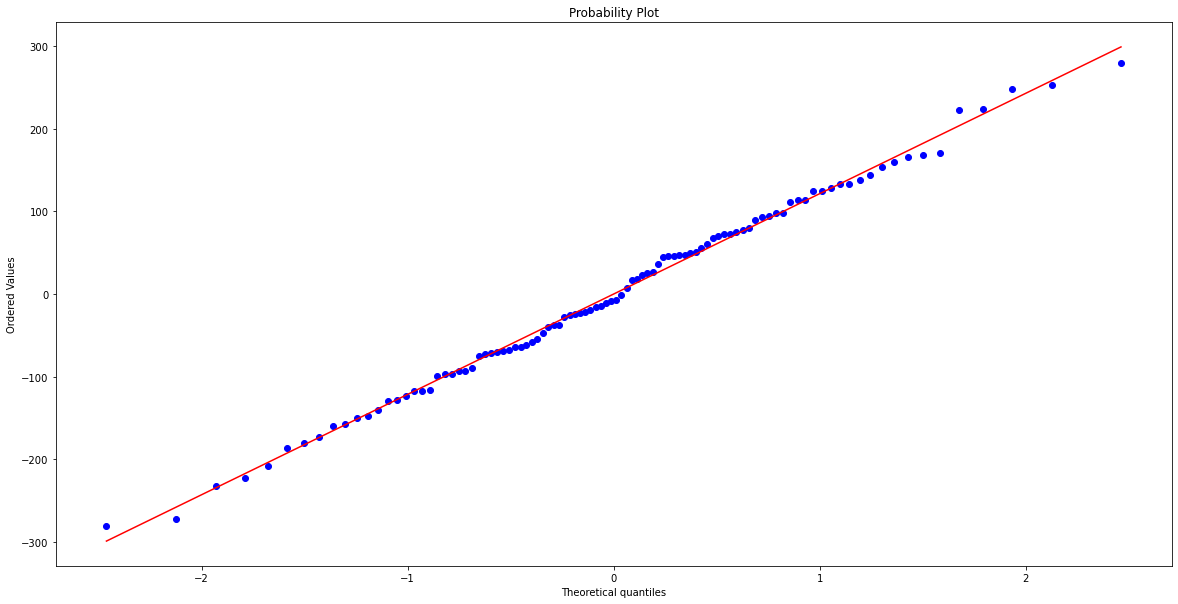

In [17]:
from scipy.stats import probplot

_ = probplot(residuals, plot=plt)

The plot shows a fairly straight line, which suggests a Normal distribution of the data.

#### All the linear regression assumptions checked out, so we continue assuming the dependence between $x$ and $y$ is best modeled with a linear function.

But now, let us try and get a more precise model, wich takes into account measurement errors in $x$.

### Deming Regression

We use [Deming regression](https://en.wikipedia.org/wiki/Deming_regression), which is a method that can be used when the errors for the two variables $x$ and $y$ are assumed to be independent and normally distributed, and the ratio of their variances, denoted δ, is known.
In our case, it is given that "You know that the technique used for measuring $x$ is
twice as better than that for measuring $y$ in the sense of error variance, i.e. the error in $x$ is twice
as small as the error in $y$", so we conclude that δ = 2.

In [18]:
def deming_regression(data: pd.DataFrame) -> Tuple[float, float]:
    delta = 2 # see discussion above

    cov = data.cov()
    mean_x = data['x'].mean()
    mean_y = data['y'].mean()
    s_xx = cov['x']['x']
    s_yy = cov['y']['y']
    s_xy = cov['x']['y']

    coeff = (s_yy  - delta * s_xx + np.sqrt((s_yy - delta * s_xx) ** 2 + 4 * delta * s_xy ** 2)) / (2 * s_xy)
    intercept = mean_y - coeff  * mean_x

    return coeff, intercept

In [19]:
coeff, intercept = deming_regression(df_clean)
coeff, intercept

(3.462727082054028, 11.027811833142607)

Using Deming Regression, we get different values for the coefficient and the intercept, compared with the Linear Regression one.
The new model is:

In [20]:
f'y = {coeff} * x + {intercept}'

'y = 3.462727082054028 * x + 11.027811833142607'

Let us compare the two linear estimators on the same plot:

Text(0.5, 1.0, 'Linear Regression vs. Deming Regression')

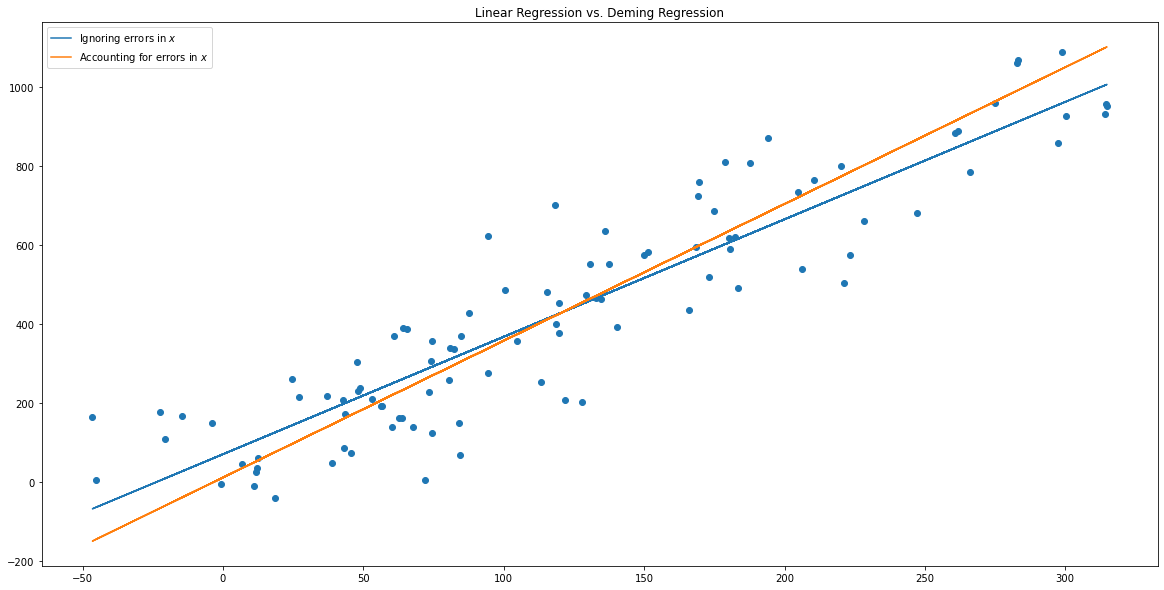

In [21]:
plt.scatter(x=X_clean, y=y_clean)
plt.plot(X_clean, lin_reg_clean.predict(X_clean), label='Ignoring errors in $x$')
plt.plot(X_clean, [intercept + coeff * x for x in X_clean], label='Accounting for errors in $x$')
plt.legend()
plt.title('Linear Regression vs. Deming Regression')